In [6]:
! source activate qutip-env

# GRAPE calculation of control fields for cnot implementation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
from qutip import *
from qutip.control import *

In [3]:
T = 2 * np.pi 
times = np.linspace(0, T, 500)

In [4]:
U = cnot()
R = 500
H_ops = [tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()) +
         tensor(sigmay(), sigmay()) +
         tensor(sigmaz(), sigmaz())]

H_labels = [r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
            r'$u_{2x}$', r'$u_{1y}$', r'$u_{2z}$',
            r'$u_{xx}$',
            r'$u_{yy}$',
            r'$u_{zz}$',
        ]

In [5]:
H0 = 0 * np.pi * (tensor(sigmax(), identity(2)) + tensor(identity(2), sigmax()))

c_ops = []

# This is the analytical result in the absense of single-qubit tunnelling
#g = pi/(4 * T)
#H = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))

# GRAPE

In [6]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary

In [7]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [8]:
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

u_limits = None #[0, 1 * 2 * pi]
alpha = None

In [9]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time: 102.96s. Est. time left: 00:00:15:26
20.0%. Run time: 205.56s. Est. time left: 00:00:13:42
30.0%. Run time: 320.34s. Est. time left: 00:00:12:27
40.0%. Run time: 441.04s. Est. time left: 00:00:11:01
50.0%. Run time: 543.12s. Est. time left: 00:00:09:03
60.0%. Run time: 641.82s. Est. time left: 00:00:07:07
70.0%. Run time: 737.05s. Est. time left: 00:00:05:15
80.0%. Run time: 834.37s. Est. time left: 00:00:03:28
90.0%. Run time: 2806.94s. Est. time left: 00:00:05:11
Total run time: 2918.86s


## Plot control fields for cnot gate in the presense of single-qubit tunnelling

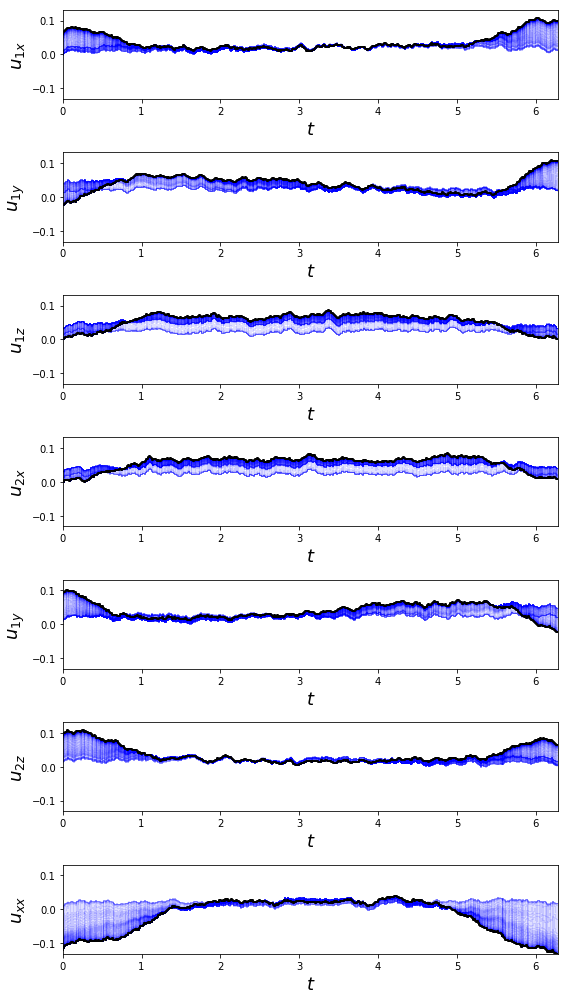

In [10]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

## Fidelity/overlap

In [11]:
U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [12]:
result.U_f

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 7.07106781e-01+7.07106781e-01j  3.18991915e-10+3.67787800e-10j
   1.09347587e-09+1.18365167e-09j  1.35414434e-09+9.44307861e-10j]
 [-3.67787976e-10-3.18989765e-10j  7.07106781e-01+7.07106781e-01j
  -6.83599939e-10-9.73512304e-10j -9.58016711e-10-7.24967000e-10j]
 [-9.44309549e-10-1.35414502e-09j  7.24965394e-10+9.58017268e-10j
  -1.61251854e-11+5.28661006e-11j  7.07106781e-01+7.07106781e-01j]
 [-1.18365160e-09-1.09347484e-09j  9.73515792e-10+6.83599575e-10j
   7.07106781e-01+7.07106781e-01j -5.28665012e-11+1.61232037e-11j]]

In [13]:
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  4.85626593e-10+3.45039011e-11j
   1.61017232e-09+6.37639208e-11j  1.62525114e-09-2.89798151e-10j]
 [-4.85625198e-10+3.45055457e-11j  1.00000000e+00-2.62014022e-10j
  -1.17175530e-09-2.04998999e-10j -1.19004919e-09+1.64791031e-10j]
 [-1.62525281e-09-2.89797439e-10j  1.19004845e-09+1.64792561e-10j
   2.59797503e-11+4.87842062e-11j  1.00000000e+00+2.96376479e-10j]
 [-1.61017155e-09+6.37645997e-11j  1.17175751e-09-2.05001724e-10j
   1.00000000e+00-3.87317400e-10j -2.59814348e-11+4.87830882e-11j]]

In [14]:
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f)) ** 2

(0.7071067811865479, 1.0000000000000009)

## Test numerical integration of GRAPE pulse

In [15]:
U_f_numerical = propagator(result.H_t, times[-1], [], options=Odeoptions(nsteps=5000), args={})
U_f_numerical

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.79376944-0.15358113j  0.51614825+0.09835793j  0.00925766-0.20755795j
  -0.02629359+0.16249327j]
 [-0.08536432+0.13774535j  0.04622701-0.36852665j  0.65509992-0.5858179j
   0.21756864-0.12696287j]
 [-0.23414069+0.45823852j  0.57925712-0.22631317j -0.42595216+0.01007404j
   0.40788217-0.02298054j]
 [-0.11749685-0.2036471j   0.32431134+0.30664892j  0.0543204 +0.00283617j
  -0.12050173-0.85324807j]]

In [16]:
U_f_numerical / U_f_numerical[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.60367552+0.2407136j   0.06000919-0.24987315j
  -0.07010855+0.19114608j]
 [-0.13602648+0.14721434j  0.14272365-0.43665953j  0.9331634 -0.55746868j
   0.29403557-0.10305833j]
 [-0.39199531+0.50144969j  0.75659553-0.13872337j -0.51962258-0.0878469j
   0.50071174+0.06792821j]
 [-0.09483422-0.27490583j  0.32177872+0.4485787j   0.06529768+0.01620705j
   0.05414492-1.06445573j]]

In [17]:
_overlap(result.U_f, U_f_numerical).real, abs(_overlap(result.U_f, U_f_numerical))**2

(0.13434089662916643, 0.12435998062659358)

# Process tomography

## Ideal cnot gate

In [18]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

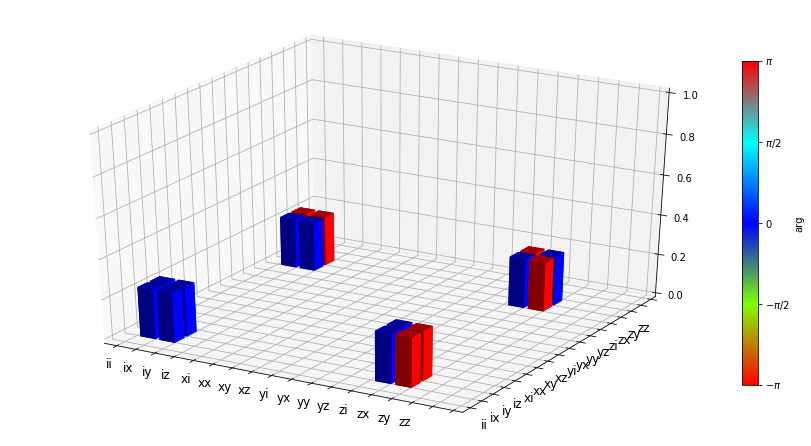

In [19]:
fig = plt.figure(figsize=(12,6))

U_i_s = to_super(U)

chi = qpt(U_i_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## cnot gate calculated using GRAPE

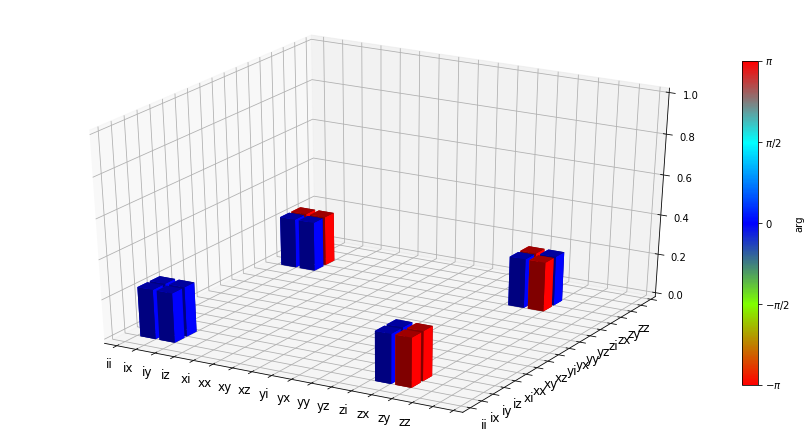

In [20]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result.U_f)

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [21]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.14.3
SciPy,1.1.0
matplotlib,3.0.2
Cython,0.28.1
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.3.1
Python,"3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]"
OS,posix [darwin]
